### Analysis of Nanopore long reads: DMS analysis

Data preprocessing was already performed (see `Nanopore_filtering_anlignment_processing.py`), which includes quality filtering, alignment and processing of the reads to force them into the right frame (i.e. get rid of indels due to Nanopore sequencing errors). 



In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import pysam
from functions_ import *
from plotting import *
from utils import *
import csv
from Nanopore_functions import *
from Bio import SeqIO
from matplotlib import patches
import gzip 
from matplotlib.colors import LinearSegmentedColormap
import ast 
import json 

ref_WT = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGCGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCGCAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:] # from 48 because all reads were cut to this start position during processing of the reads --> see process_Nanopore_reads.py 

ref_R5 = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGAGGAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCGCATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGCGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCGCTATAGCGAACTGCTGGCGATTAACCTGATAGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCGAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCACAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:]## R5

ref_R2 = "TAATGGAAACTTCCTCATGAAAAAGTCTTTAGTCCTCAAAGCCTCTGTAGCCGTTGCTACCCTCGTTCCGATGCTGTCTTTCGCTGCTGAGGGTGACGATCCCGCAAAAGCGGCCTTTGACTCCCTGCAAGCCTCAGCGACCGAATATATCGGTTATGCGTGGGCGATGGTTGTTGTCATTGTCGGCGCAACTATCGGTATCAAGCTGTTTAAGAAATTCACCTCGAAAGCAAGTTGATAAACTGATACAATTAAAGGCTCCTTTTGGAGCCTTTTTTTTTGGAGTAAGGAGGAAAAATGTCCGCGAAAGCGCAGAACGATCCGCTGCTGCCGGGCTATAGCTTTAACGCACATCTGGTGGCGGGCCTGACCCCGATTGAAGCGAACGGCTATCTGGATTTTTTTATTGATCGCCCGCTGGGCATGAAAGGCTATATTCTGAACCTGACCATTCGCGGCCAGGGCGTGGTGAAAAACCAGGGCCGCGAATTTGTGTGCCGCCCGGGCGATATTCTGCTGTTTCCGCCGGGCGAAATTCATCATTATGGCCGCCATCCGGAAGCGCGAGAATGGTATCATCAGTGGGTGTATTTTCGCCCGCGCGCGTATTGGCATGAATGGCTGAACTGGCCGAGCATTTTTGCGAACACCGGCTTTTTTCGCCCGGATGAAGCGCATCAGCCGCATTTTAGCGATCTGTTTGGCCAGATTATTAACGCGGGCCAGGGCGAAGGCCTCTATAGCGAACTGCTGACAATTAACCTGCTGGAACAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGCCAGTATATTAGCGATCATCTGGCGGATAGCAACTTTGATATTGCGAGCGTGGCGCAGCATGTGTGCCTGAGCCCTAGCCGCCTGAGCCATCTGTTTCGCCAGCAGCTGGGCATTAGCGTGCTGAGCTGGCGCGAAGATCAGCGCATTAGCCAGGCGAAACTGCTGCTGAGCACCACCCGCATGCCGATTGCGACCGTGGGCCTCAACGTGGGCTTTGATGATCAGCTGTATTTTAGCCGCGTGTTTAAAAAATGCACCGGCGCGAGCCCGAGCGAATTTCGCGCGGGCTGCGAAGAAAAAGTGAACGATGTGGCGGTGAAACTGAGCGGGTAAGGCTAATGGAGATTTTCAACATGGGCTAGCACAGCCCTAGGTATTATGCTAGCGTGGTGTCTGCGTAATAAGGAGTCTTAATCATGCCAGTTCTTTTGGGTATTCCGTTATTATTGCGTTTCCTCGGTTTCCTTCTGGTAACTTTGTTCGGCTATCTGCTTACTTTTCTCAAAAAGGGCTTCGGTAAGATAGCTATTGCTATTTCATTGTTTCTTGCTCTTATTATTGGGCTTAACTCAATTCTTGTGGGTTATCTCTCTGATATTAGTGCTCAATTACCCTCTGACTTTGTTCAGGGTGTTCAGTTAATTCTCCCGTCTAATGCGCTTCCCTGTTTTTATGTTATTCTCTCTGT"[48:] ## R2


annots_WT = ['M0', 'S1', 'A2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'R251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']

annots_R5 = ['M0', 'S1', 'E2', 'E3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'R146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'A152', 'I153', 'N154', 'L155', 'I156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'H251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']

annots_R2 = ['M0', 'S1', 'A2', 'K3', 'A4', 'Q5', 'N6', 'D7', 'P8', 'L9', 'L10', 'P11', 'G12', 'Y13', 'S14', 'F15', 'N16', 'A17', 'H18', 'L19', 'V20', 'A21', 'G22', 'L23', 'T24', 'P25', 'I26', 'E27', 'A28', 'N29', 'G30', 'Y31', 'L32', 'D33', 'F34', 'F35', 'I36', 'D37', 'R38', 'P39', 'L40', 'G41', 'M42', 'K43', 'G44', 'Y45', 'I46', 'L47', 'N48', 'L49', 'T50', 'I51', 'R52', 'G53', 'Q54', 'G55', 'V56', 'V57', 'K58', 'N59', 'Q60', 'G61', 'R62', 'E63', 'F64', 'V65', 'C66', 'R67', 'P68', 'G69', 'D70', 'I71', 'L72', 'L73', 'F74', 'P75', 'P76', 'G77', 'E78', 'I79', 'H80', 'H81', 'Y82', 'G83', 'R84', 'H85', 'P86', 'E87', 'A88', 'R89', 'E90', 'W91', 'Y92', 'H93', 'Q94', 'W95', 'V96', 'Y97', 'F98', 'R99', 'P100', 'R101', 'A102', 'Y103', 'W104', 'H105', 'E106', 'W107', 'L108', 'N109', 'W110', 'P111', 'S112', 'I113', 'F114', 'A115', 'N116', 'T117', 'G118', 'F119', 'F120', 'R121', 'P122', 'D123', 'E124', 'A125', 'H126', 'Q127', 'P128', 'H129', 'F130', 'S131', 'D132', 'L133', 'F134', 'G135', 'Q136', 'I137', 'I138', 'N139', 'A140', 'G141', 'Q142', 'G143', 'E144', 'G145', 'L146', 'Y147', 'S148', 'E149', 'L150', 'L151', 'T152', 'I153', 'N154', 'L155', 'L156', 'E157', 'Q158', 'L159', 'L160', 'L161', 'R162', 'R163', 'M164', 'E165', 'A166', 'I167', 'N168', 'E169', 'S170', 'S1', 'G2', 'L404', 'A405', 'T406', 'T407', 'L408', 'E409', 'R410', 'I411', 'E412', 'K413', 'N414', 'F415', 'V416', 'I417', 'T418', 'D419', 'P420', 'R421', 'L422', 'P423', 'D424', 'N425', 'P426', 'I427', 'I428', 'F429', 'A430', 'S431', 'D432', 'S433', 'F434', 'L435', 'Q436', 'L437', 'T438', 'E439', 'Y440', 'S441', 'R442', 'E443', 'E444', 'I445', 'L446', 'G447', 'R448', 'N449', 'C450', 'R451', 'F452', 'L453', 'Q454', 'G455', 'P456', 'E457', 'T458', 'D459', 'R460', 'A461', 'T462', 'V463', 'R464', 'K465', 'I466', 'R467', 'D468', 'A469', 'I470', 'D471', 'N472', 'Q473', 'T474', 'E475', 'V476', 'T477', 'V478', 'Q479', 'L480', 'I481', 'N482', 'Y483', 'T484', 'K485', 'S486', 'G487', 'K488', 'K489', 'F490', 'W491', 'N492', 'L493', 'F494', 'H495', 'L496', 'Q497', 'P498', 'M499', 'R500', 'D501', 'Q502', 'K503', 'G504', 'D505', 'V506', 'Q507', 'Y508', 'F509', 'I510', 'G511', 'V512', 'Q513', 'L514', 'D515', 'G516', 'T517', 'E518', 'H519', 'V520', 'R521', 'D522', 'A523', 'A524', 'E525', 'R526', 'E527', 'G528', 'V529', 'M530', 'L531', 'I532', 'K533', 'K534', 'T535', 'A536', 'E537', 'N538', 'I539', 'D540', 'E541', 'A542', 'A543', 'K544', 'G3', 'S4', 'L171', 'H172', 'P173', 'P174', 'M175', 'D176', 'N177', 'R178', 'V179', 'R180', 'E181', 'A182', 'C183', 'Q184', 'Y185', 'I186', 'S187', 'D188', 'H189', 'L190', 'A191', 'D192', 'S193', 'N194', 'F195', 'D196', 'I197', 'A198', 'S199', 'V200', 'A201', 'Q202', 'H203', 'V204', 'C205', 'L206', 'S207', 'P208', 'S209', 'R210', 'L211', 'S212', 'H213', 'L214', 'F215', 'R216', 'Q217', 'Q218', 'L219', 'G220', 'I221', 'S222', 'V223', 'L224', 'S225', 'W226', 'R227', 'E228', 'D229', 'Q230', 'R231', 'I232', 'S233', 'Q234', 'A235', 'K236', 'L237', 'L238', 'L239', 'S240', 'T241', 'T242', 'R243', 'M244', 'P245', 'I246', 'A247', 'T248', 'V249', 'G250', 'L251', 'N252', 'V253', 'G254', 'F255', 'D256', 'D257', 'Q258', 'L259', 'Y260', 'F261', 'S262', 'R263', 'V264', 'F265', 'K266', 'K267', 'C268', 'T269', 'G270', 'A271', 'S272', 'P273', 'S274', 'E275', 'F276', 'R277', 'A278', 'G279', 'C280', 'E281', 'E282', 'K283', 'V284', 'N285', 'D286', 'V287', 'A288', 'V289', 'K290', 'L291', 'S292', 'G293','*294']

start_arac =ref_WT.index("ttttttggagtaaggaggaaaa".upper()) + len("ttttttggagtaaggaggaaaa")## ref seq right before AraC start
end_arac = ref_WT.index("ggctaatggagattttcaacatgggct".upper()) ## ref seq right after AraC end


In [3]:
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", [
    #"#2C3E5E",  
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
] , N=256)


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import matplotlib

custom_params = {"axes.spines.right": False, "axes.spines.top": False,'axes.linewidth':1}
sns.set_theme(context="paper",
              style='ticks',
              palette="Greys_r",rc=custom_params
             )
plt.rcParams['svg.fonttype'] = 'none'
lw = 1
lw = 1
fs = 7
hi = 10.5 *0.75 # 6.69291
wi3 = 2.24 # 7.08661
wi2 = 4.76
wi1 = 7.24
nr = 5

short_fn = np.vectorize(lambda x: x[:5])
#matplotlib.rcParams.update({'font.size': fs})
matplotlib.rcParams['axes.linewidth'] = 1
sns.set_context("paper", rc={"font.size":fs,
                             "axes.titlesize":fs+1,
                             "axes.labelsize":fs,
                             'axes.linewidth':1,    
                            "xtick.labelsize": fs,
                            "ytick.labelsize": fs,
                            "legend.fontsize": fs,
                            "legend.title_fontsize": fs+1}) 

## Nanopore DMS analysis 
First, we calculate the mutation enrichment. 
Below, we then plot the enrichment in different ways, and look at cooccurrence of mutations. 

In [4]:
### set the right paramters of the data folders to be analyzed
data_folder = "Nanopore_P0115" 
quality = 20 
barcodenumbers = ["01" ,"02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "23" ] ## which barcodes to analyze
barcodenumbers = ["24"]

barcodenumbers = [ "01" ,"02", "03", "04", "05", "06", "07", "08", "09" ]
data_folder = "Nanopore_P0109"
data_type = "AA" ## analyze the data on the DNA or AA or Codons level

In [ ]:
### analyze the mutation enrichment
## make sure to update the reference sequence, to which the reads should be compared, accordingly (see below, ref and annots)

data_type = "Codons"
for barcodenumber in ["24"]:
    barcode = "barcode"+barcodenumber

    with open(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f: ## please set the right path
        reader = csv.reader(f)
        all_reads = list(reader)

    all_reads = [read[0] for read in all_reads]
    print(len(all_reads), "total reads are analyzed")

    ref = ref_WT #ref_R5 if barcode in ["barcode06", "barcode07", "barcode08", "barcode09"] else ref_R2 ### please change accordingly
    annots = annots_WT #annots_R5 if barcode in ["barcode06", "barcode07", "barcode08", "barcode09"] else annots_R2


    indels = pd.read_csv(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/indels.csv", index_col=0) ## please set the right path
    indels = indels/len(all_reads)

    all_variants, enrichment_counts,enrichment_relative, indels_freq = characterize_DMS_Nanopore(aligned_reads = all_reads, ref = ref, data_type = data_type)

    output_folder = f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen" ## please set the right path
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    enrichment_counts.to_csv(f"{output_folder}/enrichment_counts_{data_type}.csv")
    enrichment_relative.to_csv(f"{output_folder}/enrichment_relative_{data_type}.csv")
    all_variants.to_csv(f"{output_folder}/all_variants_{data_type}.csv")

    ## cut to region of interest
    start_arac =ref.index("ttttttggagtaaggaggaaaa".upper()) + len("ttttttggagtaaggaggaaaa")## ref seq right before AraC start
    end_arac = ref.index("ggctaatggagattttcaacatgggct".upper()) ## ref seq right after AraC end

    if data_type == "AA" or data_type == "Codons": 
        araclov2_enr = enrichment_relative.iloc[:,start_arac//3:end_arac//3]
        araclov2_enr.columns = annots if data_type == "AA" else [ref[i:i+3]+str(int(i/3)) for i in range(start_arac,end_arac,3)]
        araclov2_enr.to_csv(f"/{output_folder}/enrichment_relative_roi_{data_type}.csv")
    else: 
        araclov2_enr = enrichment_relative.iloc[:,start_arac:end_arac]
        araclov2_enr.columns = [ref_nt + str(i) for i, ref_nt in enumerate(ref[start_arac:end_arac])]
        araclov2_enr.to_csv(f"{output_folder}/enrichment_relative_roi_{data_type}.csv")

    print("Barcode"+barcodenumber+" done")

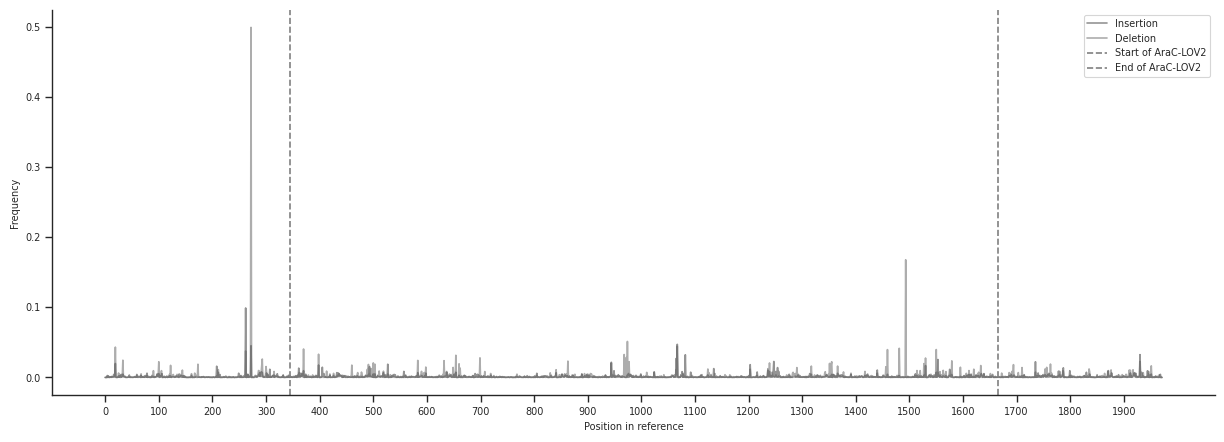

In [125]:
## plot the observed indels, that were found during processing of the Nanopore reads 
fig, axes = plt.subplots(figsize=(15, 5))
plt.plot(indels.loc["I"], label = "Insertion", alpha = 0.5)
plt.plot(indels.loc["D"], label = "Deletion", alpha = 0.5)
plt.axvline(start_arac -48 , color = "grey", linestyle = "--", label = "Start of AraC-LOV2")
plt.axvline(end_arac -48 , color = "grey", linestyle = "--", label = "End of AraC-LOV2")
plt.xticks(list(range(0, len(indels.columns), 100)), list(range(0, len(indels.columns), 100)))
plt.xlabel("Position in reference")
plt.ylabel("Frequency")
plt.legend()
plt.show()

## Visualization 
We plot and compare the enrichment that was calculated above. 

In [4]:
data_folder = "Nanopore_P0115"
barcode = "barcode24"
quality = 20
data_type = "Codons"
FigFolder = f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/"

all_variants = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
enrichment_relative = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_{data_type}.csv", index_col = 0)
enrichment_counts = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_counts_{data_type}.csv", index_col = 0)
araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)

In [74]:
araclov2_enr.max().max() ## mutation rate of single point mutation DMS-library (barcode24)

np.float64(0.7025177667305772)

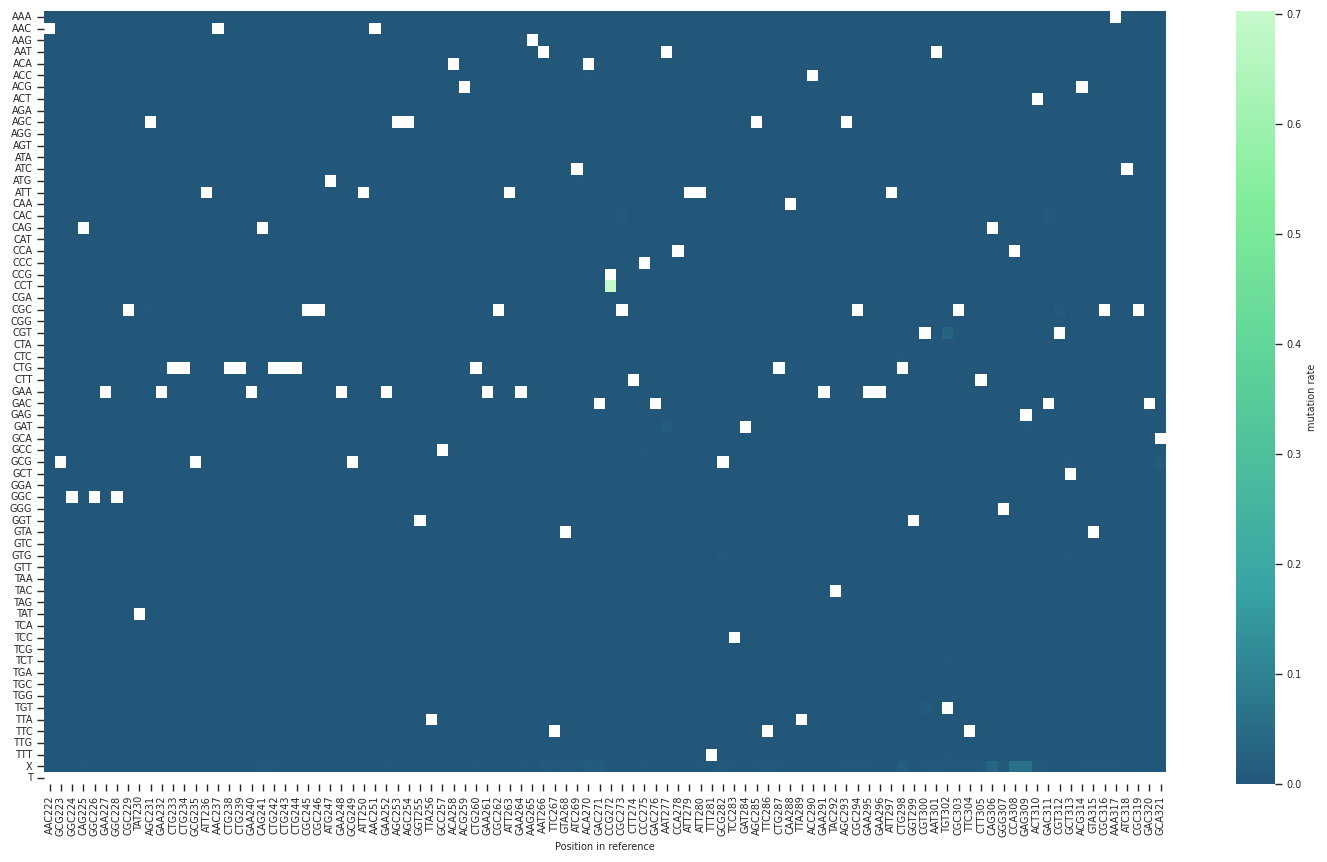

In [78]:
## plot the enrichment of the variants in the region of interest, e.g. for barcode24, i.e. the single mutant 
enr_roi = np.where(araclov2_enr ==araclov2_enr.max().max())[1][0]
araclov2_enr_roi = araclov2_enr.iloc[:,enr_roi-50: enr_roi+50]

plt.figure(figsize = (wi1*2.5,hi*1.5))
sns.heatmap(araclov2_enr_roi, cmap = custom_cmap, xticklabels = True, yticklabels=True, vmax = None, cbar_kws = {"label":"mutation rate"})
plt.xlabel("Position in reference")
plt.savefig(f"{FigFolder}/mutation_enrichment.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig(f"{FigFolder}/mutation_enrichment.png", bbox_inches = "tight", dpi = 600)

In [79]:
data_folder = "Nanopore_P0115"
barcode = "barcode23"
quality = 20
data_type = "AA"
FigFolder = f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/"


all_variants = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
enrichment_relative = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_{data_type}.csv", index_col = 0)
enrichment_counts = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_counts_{data_type}.csv", index_col = 0)
araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)

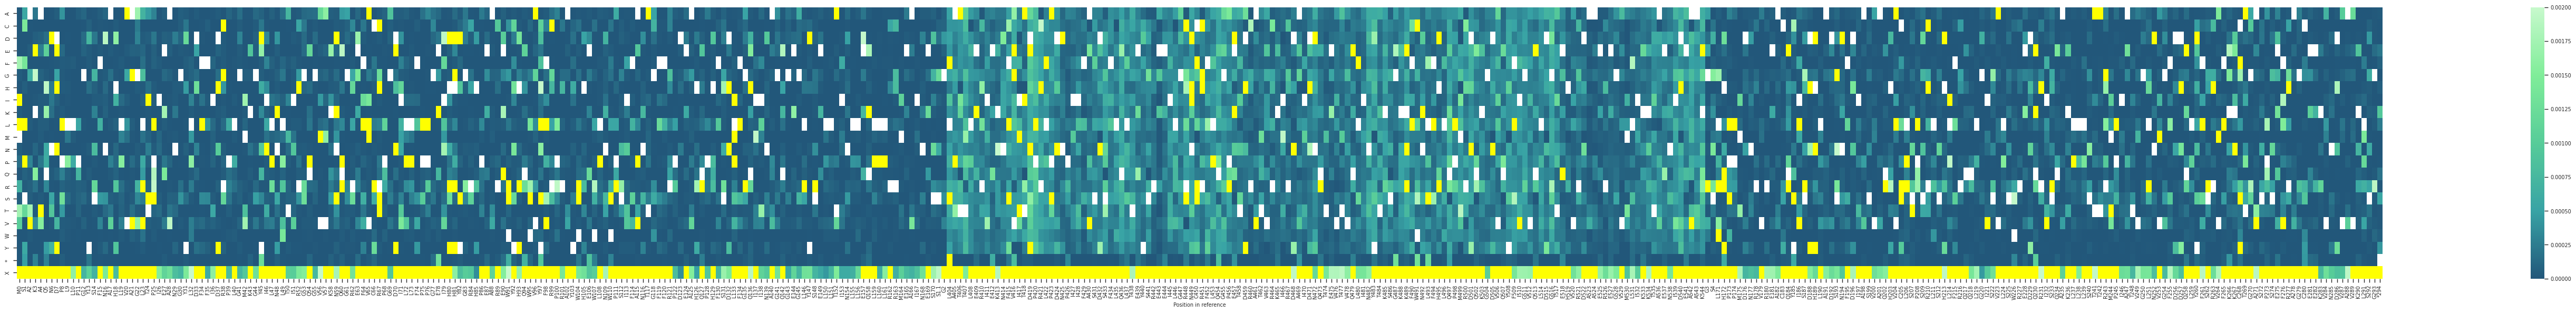

In [80]:

#  plot the enrichment for the whole sequence
plt.figure(figsize = (wi1*10,hi))

my_cmap = custom_cmap#plt.get_cmap('viridis').copy()
my_cmap.set_over('Yellow')

sns.heatmap(araclov2_enr, cmap = custom_cmap, xticklabels = True, yticklabels=True, vmax = 0.002)
plt.xlabel("Position in reference")
plt.savefig(f"{FigFolder}/mutation_enrichment.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig(f"{FigFolder}/mutation_enrichment.png", bbox_inches = "tight", dpi = 600)

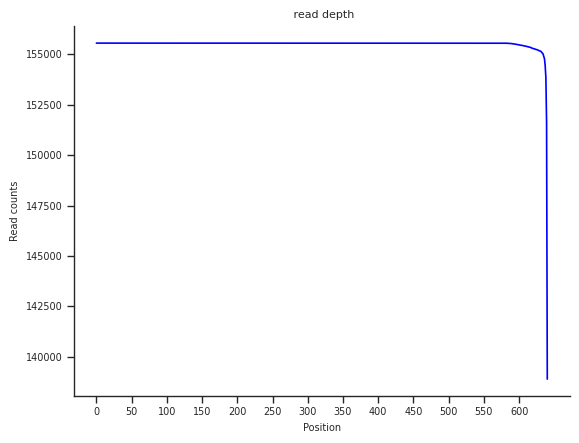

In [81]:
## plot the coverage 
coverage_plot(all_variants.sum())

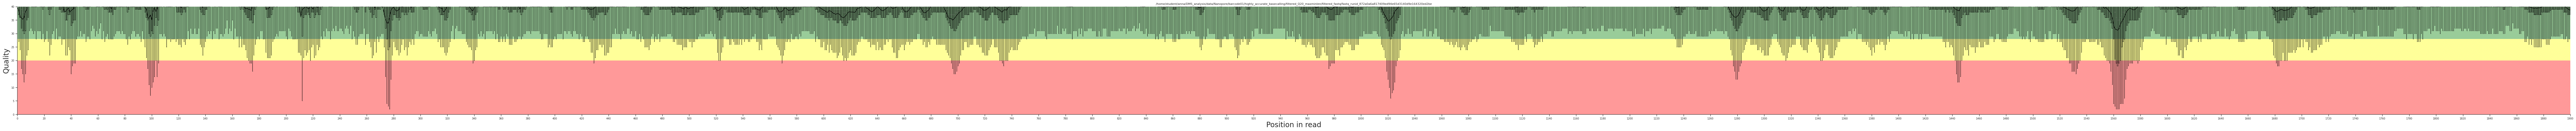

In [83]:
## we can also plot the qualitities, from the unaligned data, i.e. for each position in each read, in which bases may be skipped (thus, this does not necessarly reflect the positions within the reference!)

### the code was taken and adapted from https://dmnfarrell.github.io/python/fastq-quality-python ####

from Bio import SeqIO
from matplotlib import patches
import gzip 
bc = "barcode01"
fig, axs = plt.subplots(1, 1, figsize=(100, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
filename = f"/home/student/anna/DMS_analysis/data/Nanopore/{bc}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/filtered_fastq/fastq_runid_872a0a6a817409ed94e65d3140d9e164320ed2be_0_0.fastq.gz"

fastq_parser = SeqIO.parse(gzip.open(filename,"rt"), "fastq")
res=[]

for record in fastq_parser:
    score=record.letter_annotations["phred_quality"]
    res.append(score)
df = pd.DataFrame(res)

############ correct for coverage
df = df.fillna(0)
###### 


l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)
df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))
ax.set_xlim((0,1900))
ax.set_ylim((0,40))
ax.set_title(filename.split(".")[0][:-4])
ax.set_ylabel("Quality", fontsize = 20)
ax.set_xlabel("Position in read", fontsize = 20)
plt.show()


In [7]:
### we can also plot the quality per reference position, saved during read preprocessing 

with open(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads_base_qualitities.csv", "r", newline="") as f:
    reader = csv.reader(f)
    all_quals = [[int(value) if value.isdigit() else np.nan for value in row] for row in reader]

df = pd.DataFrame(all_quals)
df = df.iloc[:,start_arac:end_arac]
df.columns = list(range(len(df.columns)))

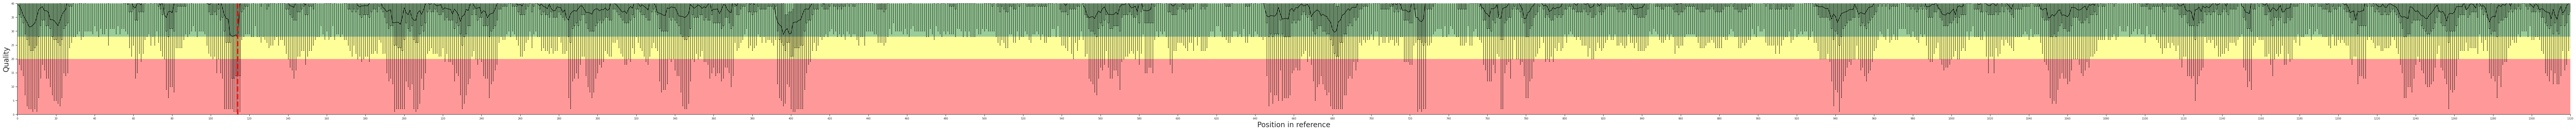

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(100, 5), layout='constrained')#plt.subplots(4, 2, figsize=(20, 20))
l = len(df.T)+1

ax = axs

rect = patches.Rectangle((0,0),l,20,linewidth=0,facecolor='r',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,20),l,8,linewidth=0,facecolor='yellow',alpha=.4)
ax.add_patch(rect)
rect = patches.Rectangle((0,28),l,12,linewidth=0,facecolor='g',alpha=.4)
ax.add_patch(rect)

df.mean().plot(ax=ax,c='black')
boxprops = dict(linestyle='-', linewidth=1, color='black')
df.plot(kind='box', ax=ax, grid=False, showfliers=False,
        color=dict(boxes='black',whiskers='black')  )
ax.set_xticks(np.arange(0, l, 20))
ax.set_xticklabels(np.arange(0, l,20))
ax.set_xlim((0,len(df.columns)))
ax.set_ylim((0,40))
#ax.set_title(filename.split(".")[0][:-4])
ax.set_ylabel("Quality", fontsize = 20)
ax.set_xlabel("Position in reference", fontsize = 20)
ax.axvline(38*3, color = "red", linestyle = "--", label = "Systematic_error", linewidth = 4)
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/base_quality_per_pos_AraCLOV2.pdf", bbox_inches='tight')
plt.show()

## Temporal data visualization
1. End days (P109)
2. Temporal data (P0115)

In [10]:
############ data of end days
### read the counts of the variants for all datasets (barcodes) that were calculated above
all_counts = {}
data_type = "AA"
quality = 20


barcodes = ["barcode01", "barcode02", "barcode03" , "barcode04", "barcode05", "barcode06", "barcode07", "barcode08", "barcode09"]
data_folder = "Nanopore_P0109"

for barcode in barcodes: 
    counts = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/all_variants_{data_type}.csv", index_col = 0)
    all_counts[barcode] = counts


In [ ]:
## plot coverages
for counts in all_counts.values():
    coverage_plot(counts.sum())

In [12]:
## read all enrichments calculated above (only for the region of interest, i.e. here, arac-lov2)
enrichments = {}
barcodes = ["barcode01", "barcode02", "barcode03" , "barcode04", "barcode05", "barcode06", "barcode07", "barcode08", "barcode09"]
data_folder = "Nanopore_P0109"

for barcode in barcodes:
    araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum()
    enrichments[barcode] = araclov2_enr


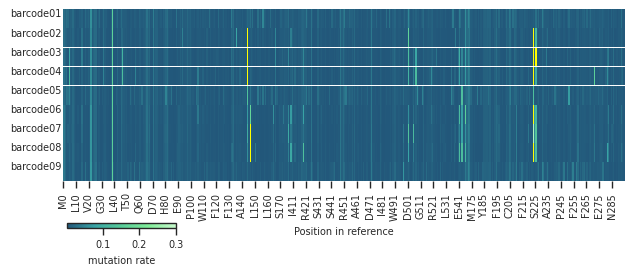

In [13]:
fig, axes = plt.subplots(9, figsize = (wi1,hi/3))
fig.subplots_adjust(hspace=0.02)

for idx, barcode in enumerate(barcodes): 
    plot_df = enrichments[barcode].copy()
    
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    my_cmap = custom_cmap#plt.get_cmap('viridis').copy()
    my_cmap.set_over('Yellow')
    annotations = annots_WT#annots_R2 #if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if idx  == len(barcodes)-1 else False, ax = axes[idx], cmap = my_cmap, vmax=0.3, cbar = False, yticklabels=False, cbar_kws={"pad" : 0.02}, linewidths = 0)
    axes[idx].set_ylabel(barcode, rotation = 0, labelpad = 20)

    if idx  == len(barcodes)-1 : 
        axes[idx].set_xlabel("Position in reference")
        ## set only every 10th annotation
        axes[idx].set_xticks(list(range(0, len(annotations), 10)))
        axes[idx].set_xticklabels(annotations[::10])

# ## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, -0.1, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate")
cbar.ax.tick_params()

plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/total_region_enrichment_heatmap_all_barcodes_Q{quality}.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/highly_acc_bcall_enrichment_heatmap_Q{quality}.png", bbox_inches = "tight")

In [14]:
# filter for highly enriched regions

mut_rate_filter_treshold = 0.1

high_mut_positions = []

for cyclename, enrichment in enrichments.items():
    total_enrichment = enrichment.iloc[:-1,:].sum()

    ## find pos with high mutation rate and low coverage
    high_mut_pos = [idx for idx, mut_rate in enumerate(total_enrichment) if mut_rate > mut_rate_filter_treshold]

    high_mut_positions.extend(high_mut_pos)

## order dict values
all_high_mut_positions = list(sorted(set(high_mut_positions))) 
all_high_mut_positions = [pos for pos in all_high_mut_positions if pos !=38]
all_high_mut_annots = [annots_WT[i] for i in all_high_mut_positions]

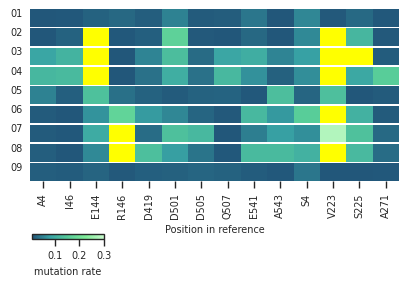

In [15]:
fig, axes = plt.subplots(9, figsize = (wi2,hi/3))
fig.subplots_adjust(hspace=0.1)

for idx, barcode in enumerate(barcodes): 
    plot_df = enrichments[barcode].copy()
    
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T
    plot_df = plot_df.iloc[:,all_high_mut_positions]

    my_cmap = custom_cmap#plt.get_cmap('viridis').copy()
    my_cmap.set_over('Yellow')
    annotations = all_high_mut_annots#annots_R2 #if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if idx == 8 else False, ax = axes[idx], cmap = my_cmap, vmax=0.3, cbar = False, yticklabels=False, cbar_kws={"pad" : 0.02}, linewidths = 0)
    #axes[idx].set_ylabel(["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"][idx])#("barcode0"+str(bc_nr+1))
    axes[idx].set_ylabel(barcode[-2:], rotation = 0, labelpad = 10)

    if idx == 8: 
        axes[idx].set_xlabel("Position in reference")
        axes[idx].set_xticklabels(annotations, rotation = 90)   

# ## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, -0.15, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate")
cbar.ax.tick_params()

plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/POGO_end_days_highly_enriched_regions.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/POGO_end_days_highly_enriched_regions.png", bbox_inches = "tight")

In [24]:
## read all enrichments calculated above (only for the region of interest, i.e. here, arac-lov2)

barcodes = ["barcode01", "barcode02", "barcode04", "barcode05", "barcode06", "barcode08", "barcode09", "barcode10", "barcode12"]
data_folder = "Nanopore_P0115"
annots = annots_R2

total_enrichments = pd.DataFrame(index = barcodes, columns = annots)
enrichments = {}

for barcode in barcodes:
    araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum()
    total_enrichments.loc[barcode] = total_enrichment
    enrichments[barcode] = araclov2_enr

### find the positions with the top 5% variance
vars = total_enrichments.var()
quantile_threshold = np.percentile(vars, 95)
top_indices = [i for i, var in enumerate(vars) if var >= quantile_threshold]
annots_top_var = [annots[i] for i in top_indices]

## mask positions with low variance
mask_pos = 38

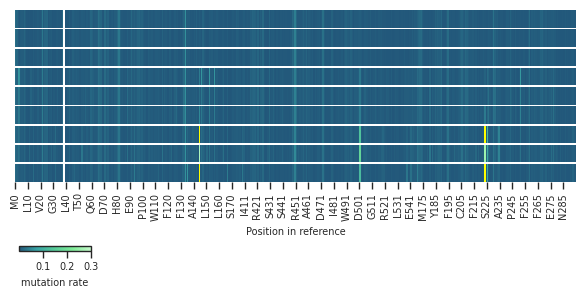

In [25]:
fig, axes = plt.subplots(9, figsize = (wi1,hi/3))
fig.subplots_adjust(hspace=0.1)

for idx, barcode in enumerate(barcodes): 

    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T
    plot_df.iloc[:,mask_pos] = np.nan

    my_cmap = plt.get_cmap(custom_cmap).copy()
    my_cmap.set_over('yellow')
    annotations = annots_R2 

    sns.heatmap(plot_df, xticklabels=annotations if idx  ==8 else False, ax = axes[idx], cmap = my_cmap, vmax=0.3, cbar = False, yticklabels=False, cbar_kws={"pad" : 0.02} )

    if idx == 8: 
        axes[idx].set_xlabel("Position in reference")
        ## set only every 10th annotation
        axes[idx].set_xticks(list(range(0, len(annotations), 10)))
        axes[idx].set_xticklabels(annotations[::10])

## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, -0.2, 0.1, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate")

plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/POGO_temporal_data_complete_region.pdf", bbox_inches = "tight")


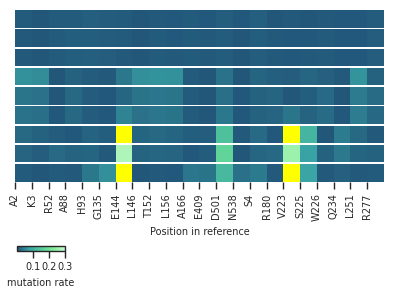

In [26]:
fig, axes = plt.subplots(9, figsize = (wi2,hi/3))
fig.subplots_adjust(hspace=0.1)

for idx, barcode in enumerate(barcodes): 

    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T
    plot_df = plot_df.iloc[:,top_indices] 

    my_cmap = plt.get_cmap(custom_cmap).copy()
    my_cmap.set_over('yellow')
    annotations = annots_top_var

    sns.heatmap(plot_df, xticklabels=annotations if idx  ==8 else False, ax = axes[idx], cmap = my_cmap, vmax=0.3, cbar = False, yticklabels=False, cbar_kws={"pad" : 0.02} )

    if idx == 8: 
        axes[idx].set_xlabel("Position in reference")
        ## set only every 10th annotation
        axes[idx].set_xticks(list(range(0, len(annotations))))
        axes[idx].set_xticklabels(annotations)

## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, -0.2, 0.1, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
cbar.set_label("mutation rate")

plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/POGO_temporal_data_complete_region.pdf", bbox_inches = "tight")


In [ ]:
#### binary colorscale
total_enrichment = pd.DataFrame(columns=annots_R5, index = ["barcode06", "barcode07", "barcode08"]) # ["barcode01", "barcode02", "barcode03", "barcode04"]

threshold = 0.05

for barcode in total_enrichment.index: 

    enr = enrichments[barcode].copy()
    sum_enr = pd.DataFrame(enr.iloc[:-1,:].sum()).T

    total_enrichment.loc[barcode] = sum_enr.values[0]

total_enrichment = total_enrichment.iloc[:,:-1]

## set all values above the threshold to 1
total_enrichment[total_enrichment > threshold] = 1
## set all values below the threshold to 0
total_enrichment[total_enrichment <= threshold] = 0

In [5]:
total_enrichment.to_csv(f"/home/student/anna/DMS_analysis/output/Nanopore/pymol/total_enrichment_R5_Bcs_Q{quality}_treshold5e-2.csv", header=True, index=False)

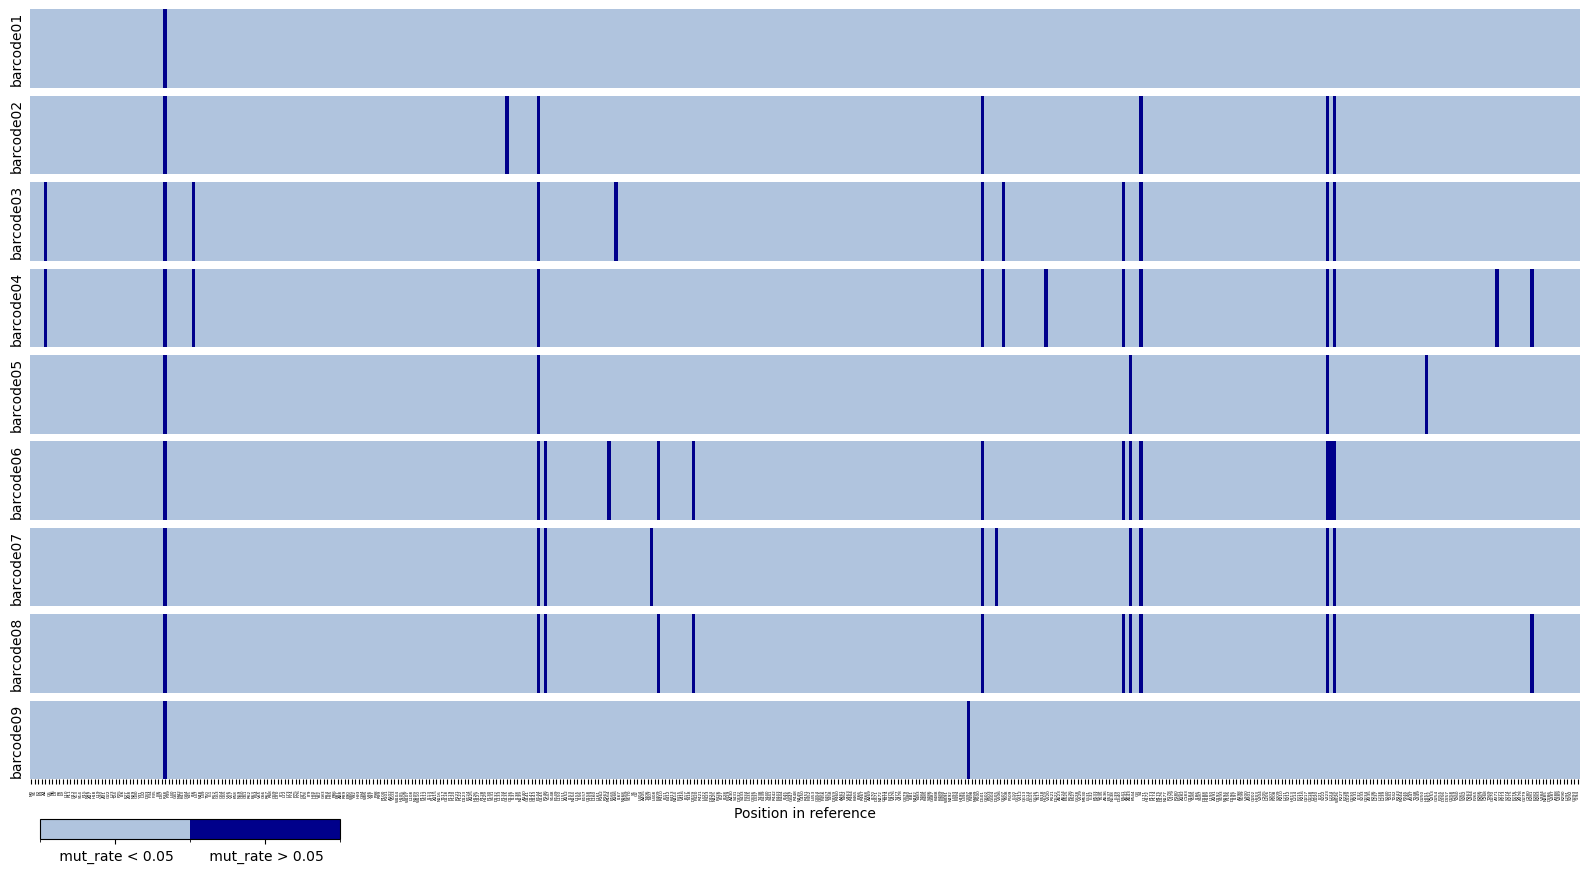

In [8]:
fig, axes = plt.subplots(9, figsize = (20,10))
fig.subplots_adjust(hspace=0.1)
threshold = 0.05

for bc_nr in range(0,9): 

    barcode = f"barcode0{bc_nr+1}"
    plot_df = enrichments[barcode].copy()
    plot_df = pd.DataFrame(plot_df.iloc[:-1,:].sum()).T

    my_cmap = plt.get_cmap('viridis').copy()
    my_cmap.set_over('orange')

    colors = ["lightsteelblue", "#00008b"]
    my_cmap = mcolors.ListedColormap(colors)
    # Create a normalization based on threshold
    norm = mcolors.BoundaryNorm([0, threshold, 1], my_cmap.N)

    annotations = annots_R2 if bc_nr <= 5 else annots_R5

    sns.heatmap(plot_df, xticklabels=annotations if bc_nr  ==8 else False, ax = axes[bc_nr], cmap = my_cmap, cbar = False, yticklabels=False, norm = norm )
    axes[bc_nr].set_ylabel("barcode0"+str(bc_nr+1))

    if bc_nr == 8: 
        axes[bc_nr].set_xlabel("Position in reference")
        axes[bc_nr].set_xticklabels(annotations,fontsize = 3)   

## add at the bottom of the figure horizontally a cbar for the relative counts
cbar_ax = fig.add_axes([0.13, 0.05, 0.15, 0.02])
cbar = fig.colorbar(axes[0].collections[0], cax=cbar_ax, orientation = "horizontal")
# cbar.set_label("mutation rate", fontsize = 15)
# cbar.ax.tick_params(labelsize=10)
## cbar = ax.collections[0].colorbar
cbar.set_ticks([threshold / 2, (threshold + 1) / 2])  # Places ticks at middle of each color range
cbar.set_ticklabels([f" mut_rate < {threshold}", f" mut_rate > {threshold}"])  # Custom labels

plt.savefig(f"/home/student/anna/DMS_analysis/output/Nanopore/highly_acc_basecalling_enrichment_heatmap_all_barcodes_Q{quality}_binary.pdf", bbox_inches = "tight")

## Cooccurrence?

63770
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFRDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATKLERIEKNFVITDPSLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRTTVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLRPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGAXPSEFRAGCEEKVNDVAVKLSG*
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLN

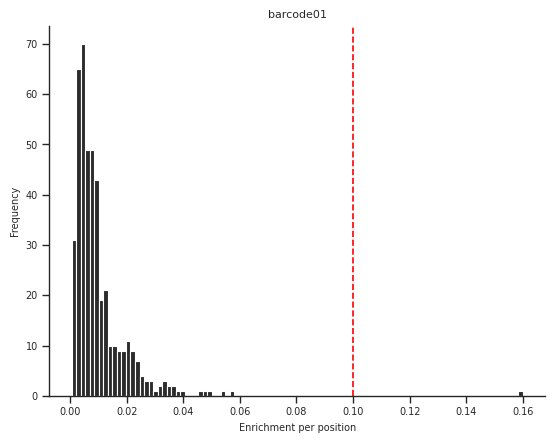

0 positions are included in variant calling
barcode01 excluded since no pos is high enough enriched (>0.1) to be included in the analysis
102222
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFRDLFDQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGXXTDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRNQKGDVQYFIGVELDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLRPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISMLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFK

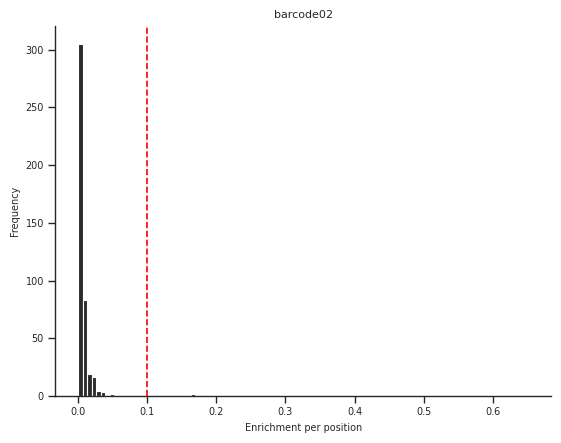

4 positions are included in variant calling
before filtering for percentage 161 variants
after filtering for percentage 11 variants
98.15401772612547 percent of all reads can be explained by the filtered genotypes
{'E144K_V223M': 43.975856469253195, 'V223M': 11.829156150339458, 'WT': 10.718827649625325, 'E144K': 6.90947154232944, 'D501N_V223M': 5.849034454422727, 'S225R': 4.731858112735027, 'D501N': 4.499031519633738, 'E144K_S225R': 4.229030932675941, 'E144K_D501N_V223M': 2.500440218348301, 'E144K_D501N': 1.6014165248185324, 'D501N_S225R': 1.3098941519438085}


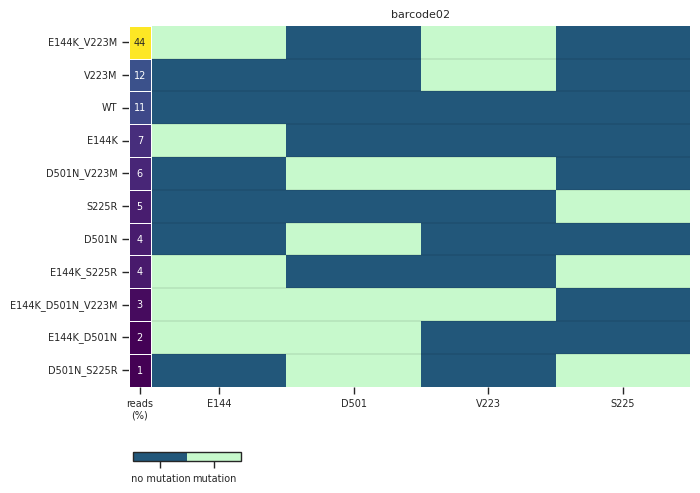

79782
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGVEGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGQETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQSVRDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISMLRWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGHLDFFIDRPLGMKGYILNLTIRGQGVVKNQGRDXXCRPGNILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLN

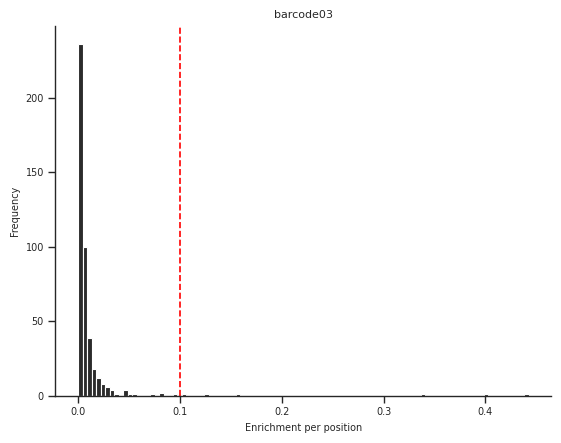

5 positions are included in variant calling
before filtering for percentage 365 variants
after filtering for percentage 20 variants
95.64814118472842 percent of all reads can be explained by the filtered genotypes
{'V223M': 17.94013687297887, 'S225R': 16.86094607806272, 'E144K_S225R': 13.979343711614147, 'WT': 9.781655009901982, 'E144K_V223M': 7.665889549021082, 'E144K': 5.018675891805168, 'V223M_S225R': 4.454638890977915, 'D501N_V223M': 3.5195908851620668, 'I46V': 2.9016570153668746, 'D501N': 2.777568875184879, 'D501N_S225R': 2.187210147652353, 'I46V_S225R': 1.6494948735303703, 'I46V_V223M': 1.5166328244466172, 'E144K_V223M_S225R': 1.3837707753628639, 'E144K_D501N_V223M': 0.8610964879296082, 'E144K_D501N_S225R': 0.6968990499110075, 'E144K_D501N': 0.6680704920909478, 'I46V_E144K_S225R': 0.6630568298613723, 'I46V_E144K': 0.6116667920082224, 'I46V_E144K_V223M': 0.5101401318593167}


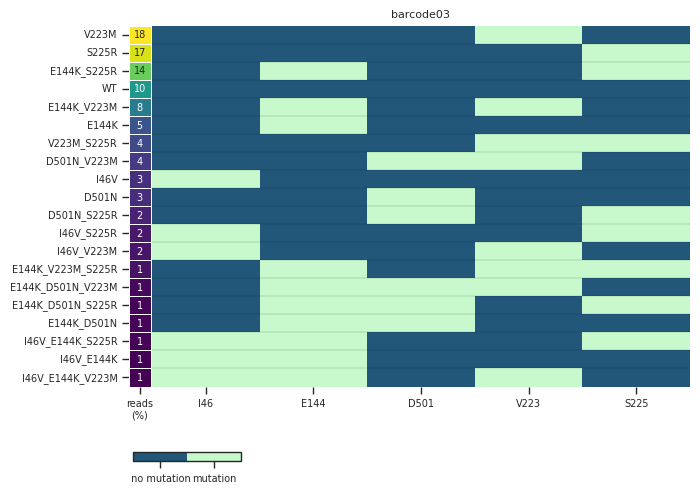

112160
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSTKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRXRAYWREWLNWPSIFXNTGFFRPDAAHQPHFSDLFGQIINAGQGKGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAEDINEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVXDVAVKLSG*
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIHRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWL

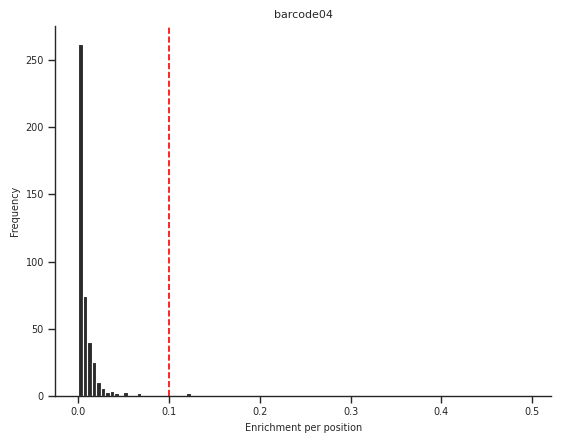

7 positions are included in variant calling
before filtering for percentage 1056 variants
after filtering for percentage 24 variants
87.05777460770327 percent of all reads can be explained by the filtered genotypes
{'E144K_V223M': 18.361269614835948, 'V223M': 12.919044222539231, 'WT': 12.331490727532097, 'E144K': 10.605385164051356, 'E144K_A271V': 7.265513552068474, 'A271V': 2.9172610556348073, 'A4T_I46V_Q507K': 2.89586305278174, 'D501N': 2.849500713266762, 'D501N_V223M': 2.8040299572039946, 'Q507K': 2.277995720399429, 'E144K_Q507K': 1.7296718972895864, 'E144K_D501N_V223M': 1.1608416547788873, 'E144K_D501N': 1.0939728958630528, 'A4T_I46V_V223M': 1.0904065620542083, 'A4T_I46V': 0.8889087018544936, 'Q507K_V223M': 0.8461126961483595, 'E144K_V223M_A271V': 0.7899429386590585, 'I46V_V223M': 0.6856276747503567, 'V223M_A271V': 0.6223252496433667, 'E144K_Q507K_V223M': 0.6196504992867332, 'I46V': 0.5964693295292439, 'A4T_E144K_V223M': 0.5795292439372326, 'A4T_I46V_E144K_V223M': 0.577746077032810

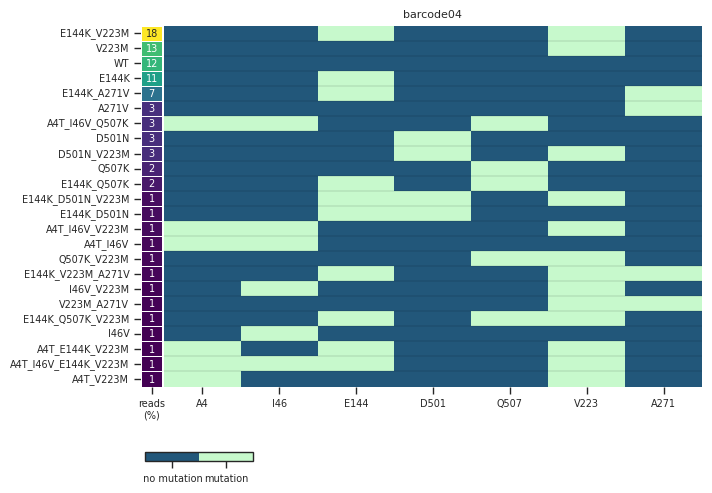

94230
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQVREFVCRPGDILLFPPGEIHHYGSHPEAREWYHQWVYFRPRAYWHEWLNWPSIFENTGFFRPDEAHQPHFSDLXRQIINAGQGEGLYSELLTINLLEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCCFLQGPETDRATVRKIRDAIDNQTEVTVQLINYXXSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREAXHCISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLRTTRMPIATVGLNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*
MSAKAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLN

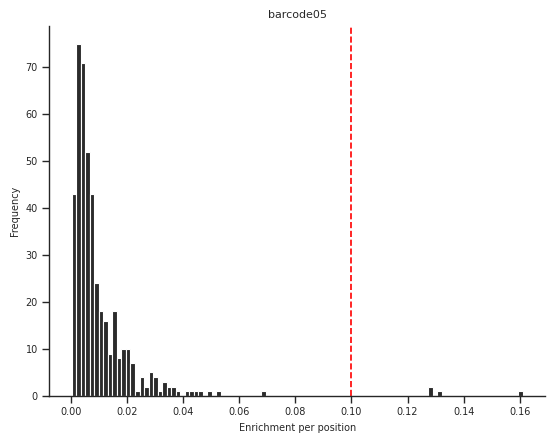

3 positions are included in variant calling
before filtering for percentage 84 variants
after filtering for percentage 7 variants
98.79550037143159 percent of all reads can be explained by the filtered genotypes
{'WT': 79.75591637482755, 'E144K_A543V_V223M': 6.564788283985992, 'E144K': 5.36453358802929, 'A543V_V223M': 4.358484559057625, 'V223M': 1.342459938448477, 'A543V': 0.7991085641515442, 'E144K_A543V': 0.610209062931126}


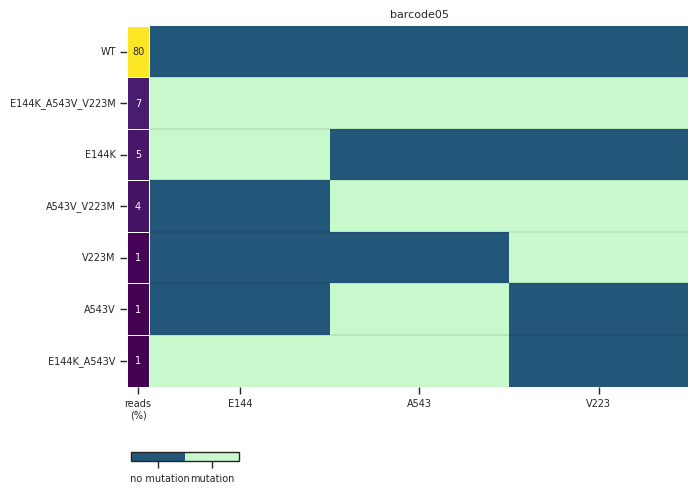

109925
MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGRYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGHNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


LXEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGRYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRSTVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLRWREDQRISQAKLLLSTTRMPIATVGHNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*
MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWL

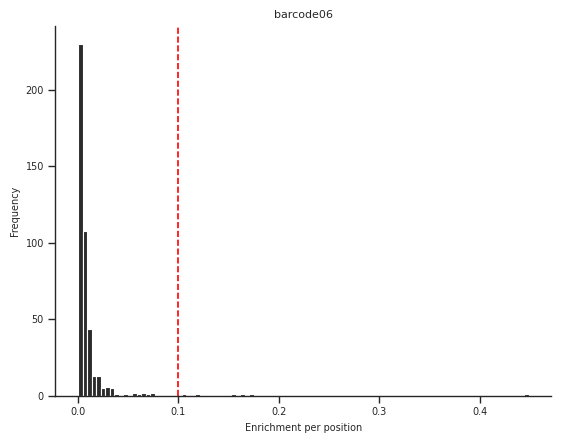

5 positions are included in variant calling
before filtering for percentage 418 variants
after filtering for percentage 16 variants
95.31953604730496 percent of all reads can be explained by the filtered genotypes
{'WT': 25.578348874232432, 'V223M': 25.574710029565612, 'R146L': 6.896520354787356, 'E541K': 6.438025926768251, 'S4R_V223M': 6.383443256765976, 'S225R': 6.291562428928815, 'R146L_V223M': 4.7132135546963845, 'S4R': 3.8653627473277234, 'E541K_V223M': 2.4398453491016605, 'V223M_S225R': 1.5856265635660678, 'R146L_E541K': 1.1789856720491245, 'S4I_V223M': 1.1617011598817375, 'R146L_S225R': 0.9743006595405959, 'R146L_S4R': 0.8523993632021833, 'R146L_S4R_V223M': 0.7204912440300205, 'E541K_S225R': 0.6649988628610416}


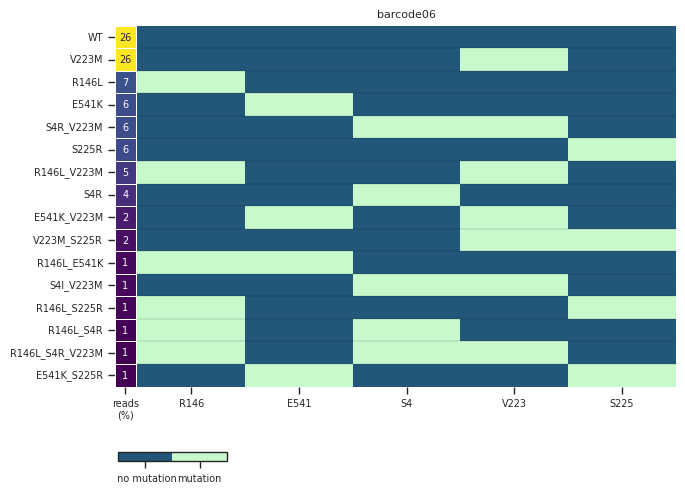

92894
MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGRYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGHNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGRYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVIAXPRLPDDPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLXRQQLGISMLSWREDERISXXXLLLSTTRMPIATVGHNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*
MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVRNQGREFMCXPGDILLFWPGKIHHYGRHPEAREWYHQWVYFRPRAYWHEWLN

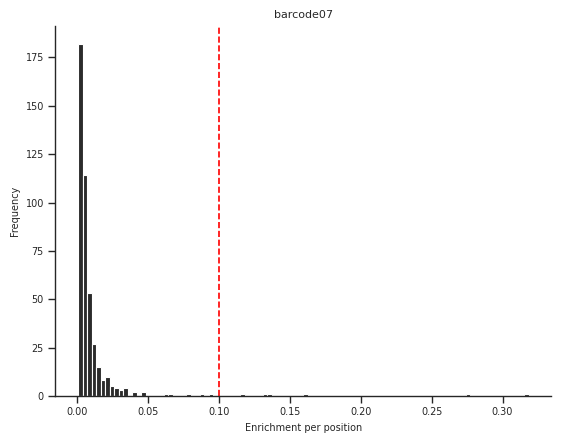

5 positions are included in variant calling
before filtering for percentage 295 variants
after filtering for percentage 14 variants
94.36777402200357 percent of all reads can be explained by the filtered genotypes
{'WT': 26.380605851831117, 'V223M': 19.345705858290092, 'R146L': 15.171055181174243, 'S225R': 9.566818093741253, 'D501N_D505N': 6.353478157900402, 'R146C': 5.034770814046117, 'R146L_V223M': 4.167115206579542, 'D501N': 2.0453420027127693, 'R146L_S225R': 1.9247744741318062, 'R146C_V223M': 1.2896419574999463, 'R146L_D501N_D505N': 0.9096389433117316, 'D505N': 0.8698085990483778, 'D501N_D505N_V223M': 0.7298641462311882, 'R146C_S225R': 0.5791547355049842}


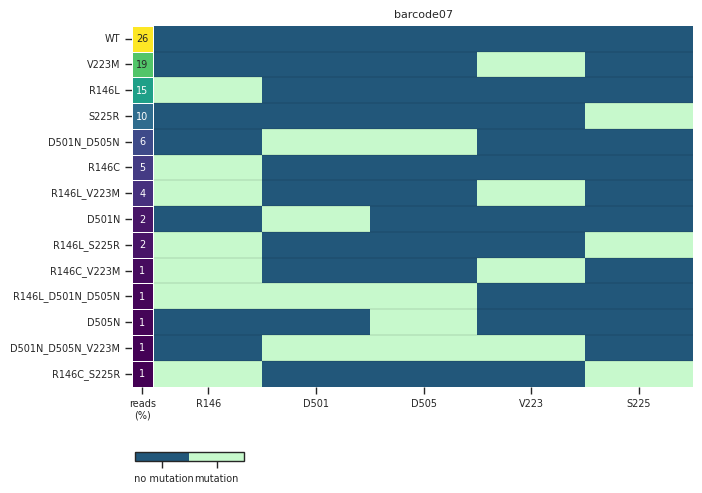

84426
MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGRYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGHNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHNYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGLYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLRPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISMLSWREDQRISQAKLLLSTTRMPIATVGHNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*
MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFHXHAYWHEWLN

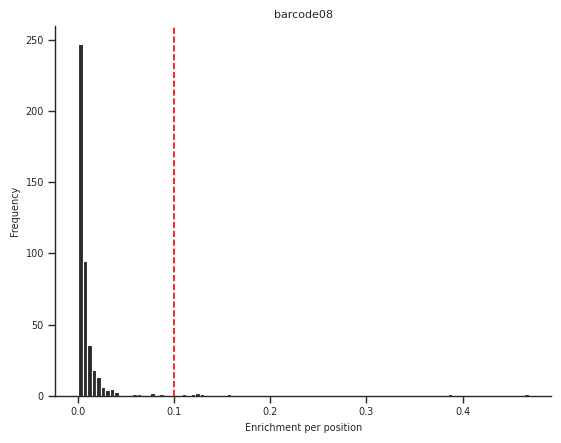

7 positions are included in variant calling
before filtering for percentage 931 variants
after filtering for percentage 24 variants
88.47629877052097 percent of all reads can be explained by the filtered genotypes
{'V223M': 15.93348020751901, 'WT': 12.224907019164712, 'R146L_V223M': 11.913391609219909, 'R146L': 7.847108710586786, 'S225R': 4.71063416483074, 'R146L_D419N': 3.6363205647549335, 'E541K_V223M': 3.574728164309573, 'A543V': 3.540378556368891, 'S4R_V223M': 3.1281832610807094, 'D419N': 2.7005898656811884, 'E541K': 2.694667519484519, 'A543V_V223M': 2.521735010541776, 'R146L_S225R': 1.71155805083742, 'R146L_E541K': 1.563499395920688, 'A543V_S225R': 1.4521592874233056, 'S4R': 1.3941202946959468, 'D419N_V223M': 1.3348968327292539, 'R146L_A543V': 1.3301589557719187, 'R146L_D419N_V223M': 1.2176343780352024, 'R146L_E541K_V223M': 1.0186435458271148, 'R146L_S4R_V223M': 0.9333617605950773, 'R146L_A543V_V223M': 0.7687205363276716, 'R146L_S4R': 0.7094970743609789, 'V223M_S225R': 0.615924004

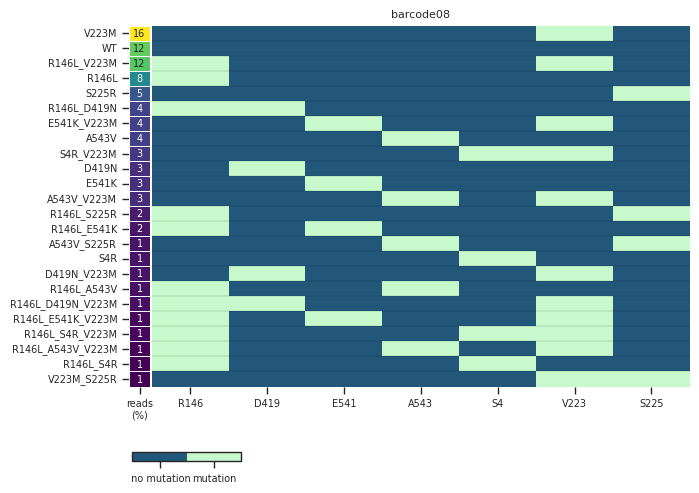

47751
MSEEAQNDPLLPGYSFNAHLVAGLTPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINAGQGEGRYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSGKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRISQAKLLLSTTRMPIATVGHNVGFDDQLYFSRVFKKCTGASPSEFRAGCEEKVNDVAVKLSG*


MSEEAQNDPLLPGYSFNAHLVAGLXPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLNWPSIFANTGFFRPDEAHQPHFSDLFGQIINXGQGEGRYSELLAINLIEQLLLRRMEAINESSGLATTLERIEKNFVITDPRLPDNPIIFASDSFLQLTEYSREEILGRNCRFLQGPETDRATVRKIRDAIDNQTEVTVQLINYTKSXKKFWNLFHLQPMRDQKGDVQYFIGVQLDGTEHVRDAAEREGVMLIKKTAENIDEAAKGSLHPPMDNRVREACQYISDHLADSNFDIASVAQHVCLSPSRLSHLFRQQLGISVLSWREDQRIS*AKLLLSTTRMPIATVGHNVGFDDQLYFRRVFKKCTGASPGEFRAGCEEKVNDVAVKLSG*
MSEEAQNDPLLPGYSFNAHLVASLXPIEANGYLDFFIDRPLGMKGYILNLTIRGQGVVKNQGREFVCRPGDILLFPPGEIHHYGRHPEAREWYHQWVYFRPRAYWHEWLN

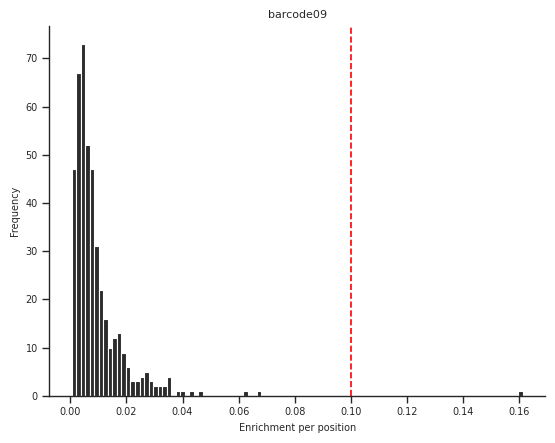

0 positions are included in variant calling
barcode09 excluded since no pos is high enough enriched (>0.1) to be included in the analysis


In [60]:
data_folder = "Nanopore_P0109"
quality = 20
combine_muts = False ##  whether to differentiate between mutations or not, set as True or False

#### below, we exclude postion R38 for the analysis, since this region is very likely a systematic error (same enrichment in all barcodes, also in (all) other analyses)

for barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05", "barcode06", "barcode07", "barcode08", "barcode09"]: 
    
    ref = ref_R2 if barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05"] else ref_R5
    annots = annots_R2 if barcode in ["barcode01", "barcode02", "barcode03", "barcode04", "barcode05"] else annots_R5

    with open(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f:
        reader = csv.reader(f)
        all_reads = list(reader) 

    all_reads = [read[0] for read in all_reads]
    # Print the data
    print(len(all_reads))


    reads_roi = [read[start_arac:end_arac] for read in all_reads]
    ref_roi = ref[start_arac:end_arac]
    all_aas = [translate_dna2aa(read) for read in reads_roi]
    ref_aa = translate_dna2aa(ref_roi) 

    print(ref_aa)
    print("\n")

    for i in all_aas[:5]: 
        print(i)

    araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum() # exclude "X" row

    plt.hist(total_enrichment, bins = 100)
    #plt.xlim(0, 0.1)
    plt.axvline(0.1, color = "red", linestyle = "--")
    plt.xlabel("Enrichment per position")
    plt.ylabel("Frequency")
    plt.title(barcode)
    plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/total_enrichment_hist.pdf", bbox_inches = "tight")
    plt.show()
    plt.close()

    #pos = set([idx for idx, mut_rate in enumerate(total_enrichment) if mut_rate > 0.1] + observed_muts_idx)
    pos =[idx for idx, mut_rate in enumerate(total_enrichment)if mut_rate > 0.1] #+ observed_muts_idx
    pos=[pos for pos in pos if pos !=38] ## exclude position with systematic error R38
    pos = list(sorted(set(pos)))
    print(len(pos), "positions are included in variant calling")
    if len(pos) == 0: 
        print(barcode, "excluded since no pos is high enough enriched (>0.1) to be included in the analysis")
        continue
    genotypes = get_genotype_dict_from_AAseqs(all_aas, ref_aa, annots, combined=combine_muts, not_masked_positions=pos)


    ## sort genotypes after size 
    genotypes_sorted = dict(sorted(genotypes.items(), key=lambda item: item[1], reverse=True))
    sum_genotypes = sum(genotypes_sorted.values())
    genotypes_sorted = {k: v/sum_genotypes*100 for k, v in genotypes_sorted.items()}
    print("before filtering for percentage",  len(genotypes_sorted), "variants")
    ## filter for variants with >0.5 percent 
    genotypes_sorted = {k: v for k, v in genotypes_sorted.items() if v > 0.5}
    print("after filtering for percentage",len( genotypes_sorted), "variants")
    print(sum(genotypes_sorted.values()), "percent of all reads can be explained by the filtered genotypes")
    print(genotypes_sorted)


    genotypes_table = pd.DataFrame(columns = ["count"] + annots, index = list(genotypes_sorted.keys()), data = 0, dtype = "float")

    for variant, count in genotypes_sorted.items(): 
        genotypes_table.loc[variant, "count"] =count
        if variant != "WT":  
            for mut in variant.split("_"): 
                mut = mut if combine_muts else mut[:-1]
                genotypes_table.loc[variant, mut] = 1.0 

    ## save 
    genotypes_table.to_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes_table_combinedmuts{combine_muts}.csv")


    ## filter genotypes_table for columns in pos 
    genotypes_table_filt = genotypes_table.iloc[:, 1:]
    genotypes_table_filt = genotypes_table_filt.iloc[:, pos]
    genotypes_table_filt= pd.concat(( genotypes_table["count"], genotypes_table_filt), axis = 1)


    fig, ax = plt.subplots(1,2, figsize=(wi1, hi*0.7), gridspec_kw={"width_ratios": [0.2, 5]})
    fig.subplots_adjust(wspace=0.005)

    sns.heatmap(genotypes_table_filt.iloc[:, :1], ax=ax[0], cmap="viridis", cbar=False, annot=True, fmt=".0f",
                linewidths=0.5, linecolor="white", cbar_kws={"label": "Occurrences"}, yticklabels=True, xticklabels=["reads\n(%)"])

    colors = ["#22577A", "#C7F9CC" ] 
    binary_cmap = mcolors.ListedColormap(colors)
    # Create a normalization based on threshold
    norm = mcolors.BoundaryNorm([0,0.5,1], binary_cmap.N)

    ax[1] = sns.heatmap(genotypes_table_filt.iloc[:,1:], cbar_kws={"label": "mutation rate"}, cmap = binary_cmap, xticklabels=True, cbar = False, yticklabels=False )
    for y in range(1, genotypes_table_filt.shape[0]):  # Iterate over columns
        ax[1].axhline(y, color="black", lw=0.1)  # Add vertical lines

    plt.title(f"{barcode}")

    ## add at the bottom of the figure horizontally a cbar for the relative counts
    cbar_ax = fig.add_axes([0.13,- 0.05, 0.15, 0.02])
    cbar = fig.colorbar(ax[1].collections[0], cax=cbar_ax, orientation = "horizontal")
    cbar.set_ticks([0.5 / 2, (0.5 + 1) / 2])  # Places ticks at middle of each color range
    cbar.set_ticklabels([f" no mutation", f"mutation"])  # Custom labels
    plt.savefig(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes_combined_heatmap_posMin1percEnr_min0_5percOcc_combinedmuts{combine_muts}.pdf", bbox_inches = "tight")
    plt.show()
    plt.close()


In [70]:
################# Cooccurrence for the temporal data ###################
### here, we filter for highly variant positions, not positions that are highly mutated (as above)!
data_folder = "Nanopore_P0115"

barcodes = ["barcode01", "barcode02", "barcode04", "barcode05", "barcode06","barcode08", "barcode09", "barcode10", "barcode12"]
annots = annots_R2
total_enrichments = pd.DataFrame(index = barcodes, columns = annots)


for barcode in barcodes:
    araclov2_enr = pd.read_csv(f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/enrichment_relative_roi_{data_type}.csv", index_col = 0)
    total_enrichment = araclov2_enr.iloc[:-1,:].sum()
    total_enrichments.loc[barcode] = total_enrichment

######### find positions with high variance (to 5% quantile)
vars = total_enrichments.var()
quantile_threshold = np.percentile(vars, 95)
top_indices = [i for i, var in enumerate(vars) if var >= quantile_threshold]
annots_top_var = [annots[i] for i in top_indices]

In [ ]:
all_positions = []
all_aas_all_barcodes = {}

quality = 20
data_type = "AA"
ref = ref_R2 
annots = annots_R2 #

## read all sequences, cut to roi and translate to AA seq
for barcode in ["barcode01", "barcode02", "barcode04", "barcode05", "barcode06","barcode08", "barcode09", "barcode10", "barcode12"]:
    with open(f"/home/student/anna/DMS_analysis/data/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/processed_reads/cleaned_reads.csv", "r", newline="") as f:
        reader = csv.reader(f)
        all_reads = list(reader)  # Convert the reader object into a list

    output_dir = f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    all_reads = [read[0] for read in all_reads]
    # Print the data
    print(len(all_reads))

    reads_roi = [read[start_arac:end_arac] for read in all_reads]
    ref_roi = ref[start_arac:end_arac]
    all_aas = [translate_dna2aa(read) for read in reads_roi]
    ref_aa = translate_dna2aa(ref_roi)

    print(ref_aa)
    print("\n")

    for i in all_aas[:5]: 
        print(i)

    all_aas_all_barcodes[barcode] = all_aas

In [ ]:

all_positions = top_indices

for barcode in  ["barcode01", "barcode02", "barcode04", "barcode05", "barcode06","barcode08", "barcode09", "barcode10", "barcode12"]:
    output_dir = f"/home/student/anna/DMS_analysis/final_output/{data_folder}/{barcode}/highly_accurate_basecalling/filtered_Q{quality}_maxminlen/genotypes/"

    print(len(all_positions), "positions are included in variant calling")
    all_aas = all_aas_all_barcodes[barcode]

    genotypes = get_genotype_dict_from_AAseqs(all_aas, ref_aa, annots, combined=False, not_masked_positions=all_positions)


    ## sort genotypes after size 
    genotypes_sorted = dict(sorted(genotypes.items(), key=lambda item: item[1], reverse=True))
    print(genotypes_sorted)

    sum_genotypes = sum(genotypes_sorted.values())
    genotypes_sorted = {k: v/sum_genotypes*100 for k, v in genotypes_sorted.items()}
    print("before filtering for percentage",  len(genotypes_sorted), "variants")    ## filter for variants with >0.5 percent 
    genotypes_sorted = {k: v for k, v in genotypes_sorted.items() if v > 0.01}
    print("after filtering for percentage",len( genotypes_sorted), "variants")
    print(sum(genotypes_sorted.values()), "percent of all reads can be explained by the filtered genotypes")

    genotypes_table = pd.DataFrame(columns = ["count"] + annots, index = list(genotypes_sorted.keys()), data = 0, dtype = "float")

    for variant, count in genotypes_sorted.items(): 
        genotypes_table.loc[variant, "count"] =count
        if variant != "WT":  
            for mut in variant.split("_"): 
                genotypes_table.loc[variant, mut] = 1.0 #[:-1]


    genotypes_table.to_csv(f"{output_dir}/genotypes_table.csv")


    ## filter genotypes_table for columns in pos 
    genotypes_table_filt = genotypes_table.iloc[:, 1:]
    genotypes_table_filt = genotypes_table_filt.iloc[:, pos]
    genotypes_table_filt= pd.concat(( genotypes_table["count"], genotypes_table_filt), axis = 1)


In [83]:
len(all_positions)

22

In [84]:
all_variants = pd.DataFrame(dtype = float)

for barcode in ["barcode01", "barcode02", "barcode04", "barcode05", "barcode06", "barcode08","barcode09", "barcode10", "barcode12"]: 
    FigFolder = f"/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/{barcode}/highly_accurate_basecalling/filtered_Q20_maxminlen/genotypes/"
    genotypes = pd.DataFrame(pd.read_csv(f"{FigFolder}/genotypes_table.csv", index_col = 0).T.iloc[0,:]).T
    genotypes.index = [barcode]    
    all_variants = pd.concat([all_variants, genotypes], axis = 0)


# all_right_linkers.fillna(0, inplace = True)
all_variants.fillna(0, inplace = True)

In [85]:
all_variants

,WT,H93Y,D501N,G135R,S4R,R277H,H93R,R52H,E144K,E409K,...,R52H_G135D_D501N_V223M,E144K_T152P_V223M,A166V_D501N_S225R,E144K_Q234*,H93Q_E144K_V223M,E409K_S4R_S225R,G135D_D501N_V223M_S225R,E144K_S225R_W226*,E144K_V223M_W226L,E144K_V223M_S225G
barcode01,89.805067,0.484813,0.426888,0.414295,0.307258,0.263184,0.255629,0.241777,0.239259,0.219110,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode02,88.670389,0.413236,0.360241,0.420176,0.231538,0.280748,0.239109,0.264345,0.223968,0.241633,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode04,88.553429,0.428970,0.326056,0.451092,0.213523,0.275079,0.240454,0.289507,0.239492,0.235645,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode05,67.349056,0.406984,1.719419,0.332791,0.909772,0.195929,0.179361,0.198090,2.417415,0.234826,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode06,71.594888,0.429933,1.605230,0.353845,0.678880,0.284406,0.197237,0.200192,1.342986,0.234912,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode08,67.306961,0.375126,2.070408,0.307577,0.636796,0.246586,0.162642,0.217075,1.958920,0.268228,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode09,10.278389,0.144681,4.598140,0.049137,0.198186,0.025115,0.027298,0.070976,6.884107,0.064424,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode10,27.769365,0.362482,8.633522,0.127272,0.396314,0.064441,0.083774,0.212656,5.367960,0.136938,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
barcode12,4.046764,0.079591,1.862431,0.026530,0.038911,0.017687,0.000000,0.033605,3.661190,0.056598,...,0.010612,0.010612,0.010612,0.010612,0.010612,0.010612,0.010612,0.010612,0.010612,0.010612


In [86]:
## filter df for linkers that have a overall occurrence of higher than 1 % 
all_variants = all_variants.loc[:, all_variants.max() > 2]
all_variants


,WT,D501N,E144K,V223M,S225R,E144K_V223M,L251H,D501N_Q234L,E144K_S225R,G135D_D501N_V223M
barcode01,89.805067,0.426888,0.239259,0.064222,0.036518,0.027704,0.000000,0.000000,0.000000,0.000000
barcode02,88.670389,0.360241,0.223968,0.054888,0.028390,0.011987,0.000000,0.000000,0.000000,0.000000
barcode04,88.553429,0.326056,0.239492,0.048091,0.049053,0.000000,0.015389,0.000000,0.000000,0.000000
barcode05,67.349056,1.719419,2.417415,0.450924,1.269215,0.270122,2.298561,0.306859,0.026652,0.000000
barcode06,71.594888,1.605230,1.342986,0.191327,0.578415,0.079043,1.112506,0.177292,0.000000,0.000000
barcode08,67.306961,2.070408,1.958920,0.940439,0.872890,1.668394,1.193584,0.276098,0.087879,0.000000
barcode09,10.278389,4.598140,6.884107,8.499626,5.449304,33.967930,0.306834,2.076861,2.320363,0.264794
barcode10,27.769365,8.633522,5.367960,4.531834,4.789599,15.119539,0.347983,2.373051,0.747519,0.414035
barcode12,4.046764,1.862431,3.661190,5.670422,1.225703,51.426449,0.021224,0.505846,2.217938,2.722015


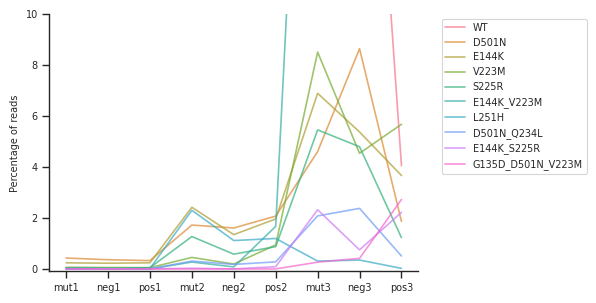

In [98]:

# Number of distinct colors
colors = sns.color_palette("husl", all_variants.shape[1]) 


fig, axis = plt.subplots(1,1, figsize=(wi2, hi/2))
for i in all_variants.columns:
    plt.plot(all_variants[i], label = i, color = colors[all_variants.columns.get_loc(i)], alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylim(-0.1,10)#
plt.xticks(range(len(["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"])), ["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"])
plt.ylabel("Percentage of reads")
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/POGO_temporal_coccurrence_lineplot_zoomin.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/POGO_temporal_coccurrence_lineplot_zoomin.png", bbox_inches = "tight", dpi = 600)

plt.show()

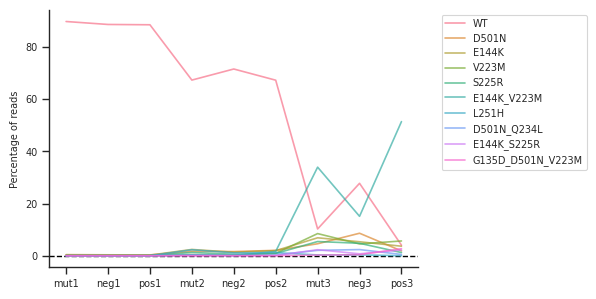

In [99]:

  # Number of distinct colors
colors = sns.color_palette("husl", all_variants.shape[1]) 


fig, axis = plt.subplots(1,1, figsize=(wi2, hi/2))
plt.axhline(0, color = "black", linestyle = "--", linewidth= 1)
for i in all_variants.columns:
    plt.plot(all_variants[i], label = i, color = colors[all_variants.columns.get_loc(i)], alpha = 0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(len(["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"])), ["mut1", "neg1", "pos1", "mut2", "neg2", "pos2", "mut3", "neg3", "pos3"])
plt.ylabel("Percentage of reads")
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/POGO_temporal_coccurrence_lineplot.pdf", bbox_inches = "tight", dpi = 600)
plt.savefig("/home/student/anna/DMS_analysis/final_output/Nanopore_P0115/POGO_temporal_coccurrence_lineplot.png", bbox_inches = "tight", dpi = 600)

plt.show()
